# Day 2: Basic Preprocessing EEG

In [1]:
import mne
from mne.datasets import eegbci

### 1. Download dan load data EEG

In [11]:
subject = 1
runs = [1]  # cukup 1 run untuk cepat
file_path = eegbci.load_data(subject=subject, runs=runs)[0]
raw = mne.io.read_raw_edf(file_path, preload=True)
before = mne.io.read_raw_edf(file_path, preload=True)
print(f"Data loaded: {file_path}")

Extracting EDF parameters from /Users/syifani/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S001/S001R01.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 9759  =      0.000 ...    60.994 secs...
Extracting EDF parameters from /Users/syifani/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S001/S001R01.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 9759  =      0.000 ...    60.994 secs...
Data loaded: /Users/syifani/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S001/S001R01.edf


/var/folders/zk/5mfnhbj13qzgxy_2dx8gcv8w0000gn/T/ipykernel_10463/4163920804.py:3: FutureWarning: The ``subject`` parameter is deprecated and will be removed in version 1.9. Use the ``subjects`` parameter (note the `s`) to suppress this warning.
  file_path = eegbci.load_data(subject=subject, runs=runs)[0]


### 2. Standarkan nama channel

In [3]:
def _std_name(name: str) -> str:
    return (name.replace('EEG ', '')
                .replace('-REF', '')
                .replace('.', '')
                .strip())

raw.rename_channels(_std_name)
raw.set_montage('standard_1020', on_missing='ignore')

<RawEDF | S001R01.edf, 64 x 9760 (61.0 s), ~4.8 MiB, data loaded>

### 3. Plot raw signal dan cek kondisi awal

Using matplotlib as 2D backend.


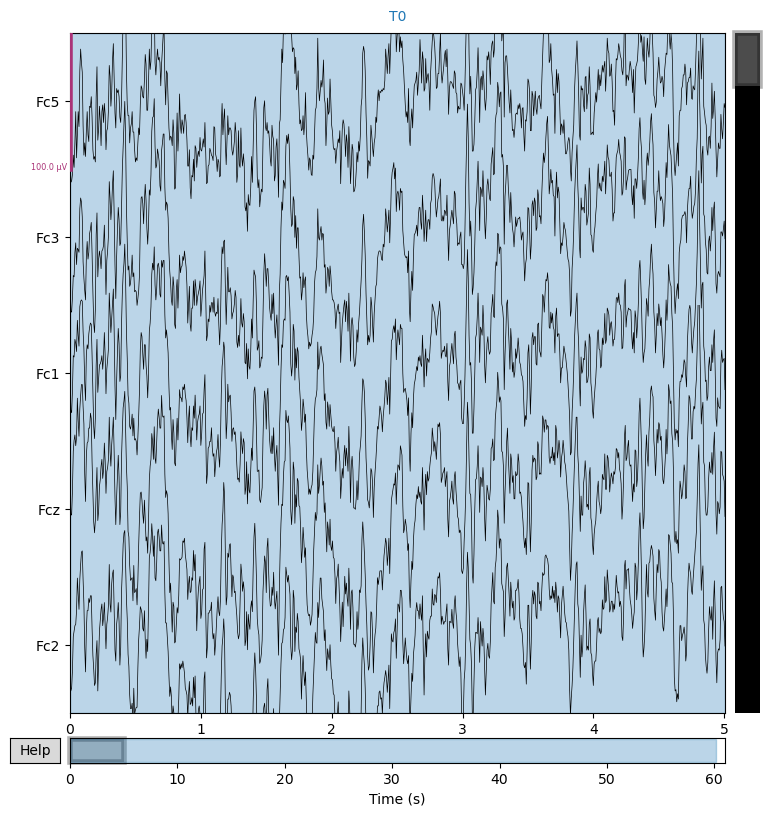

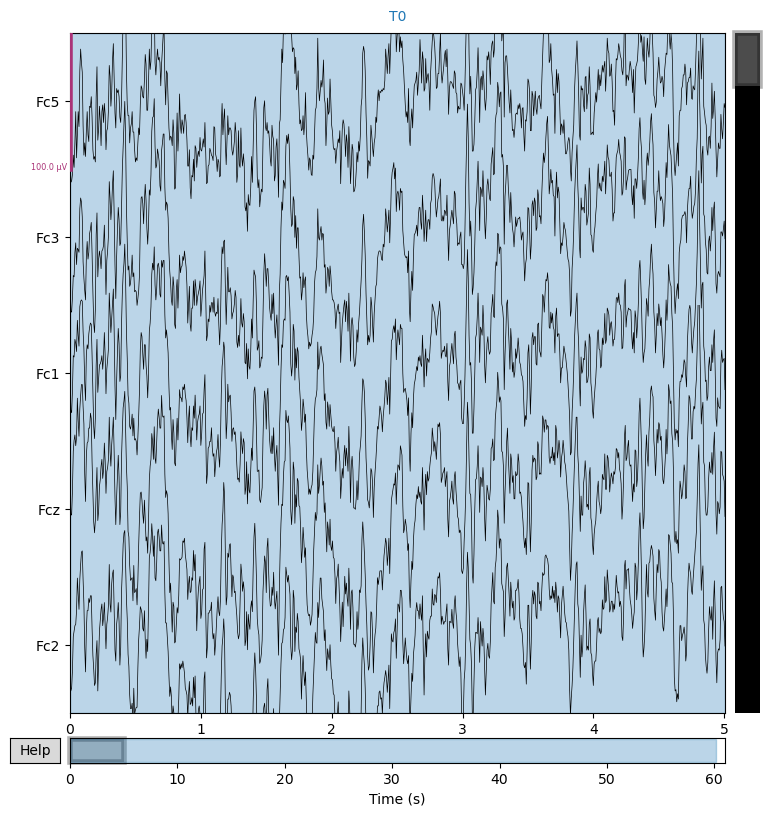

In [4]:
raw.plot(duration=5, n_channels=5, scalings=dict(eeg=50e-6), title="Raw EEG (Before Filtering)")

### 4. Average Reference

In [5]:
raw.set_eeg_reference('average', verbose=False)

<RawEDF | S001R01.edf, 64 x 9760 (61.0 s), ~4.8 MiB, data loaded>

### 5. Tambahkan notch filter

In [6]:
notch_freq = 60.0  # EEGBCI dari US, jadi 60 Hz
raw.notch_filter(freqs=[notch_freq], verbose=False)


<RawEDF | S001R01.edf, 64 x 9760 (61.0 s), ~4.8 MiB, data loaded>

### 6.Tambahkan band pass filter

In [7]:
raw.filter(l_freq=1.0, h_freq=40.0, fir_design='firwin', verbose=False)


<RawEDF | S001R01.edf, 64 x 9760 (61.0 s), ~4.8 MiB, data loaded>

### 7. Plot setelah filtering

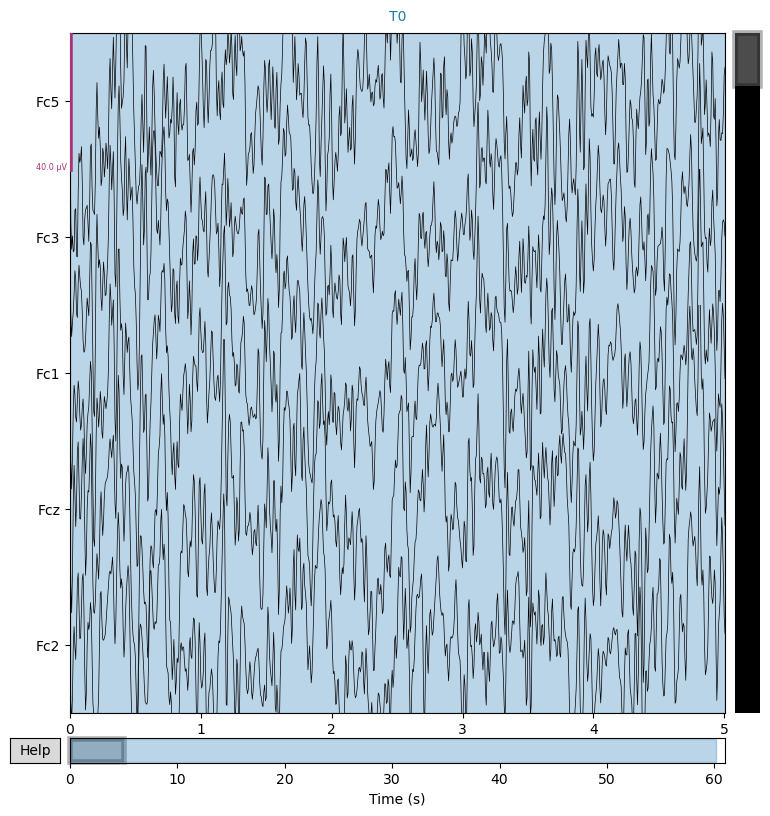

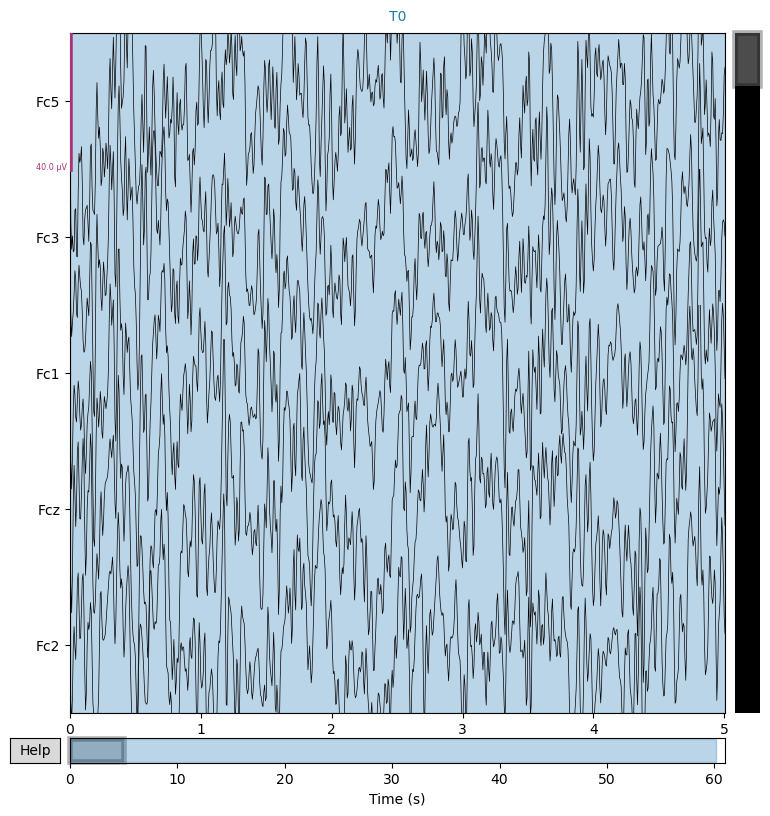

In [8]:
raw.plot(duration=5, n_channels=5, scalings=dict(eeg=20e-6), title="EEG (After Filtering)")

### 8. PSD (lihat noise sudah hilang, bandingkan dengan before nya)

NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
Effective window size : 12.800 (s)
Plotting power spectral density (dB=True).


/opt/anaconda3/lib/python3.12/site-packages/mne/viz/utils.py:158: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)


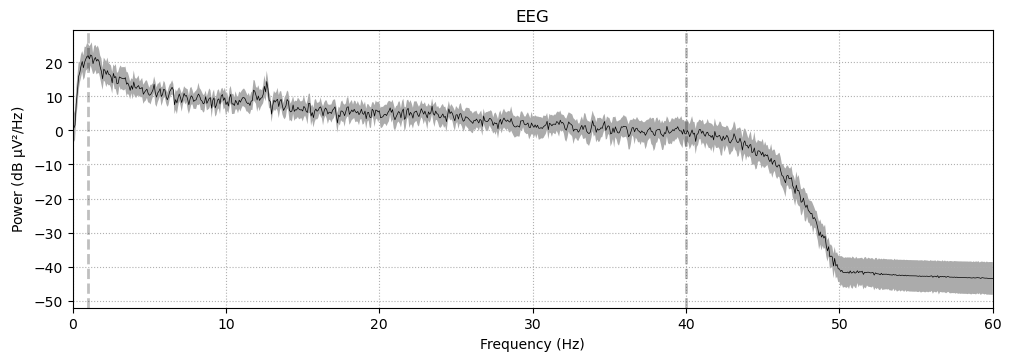

In [9]:
raw.plot_psd(fmax=60, average=True)

NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
Effective window size : 12.800 (s)
Plotting power spectral density (dB=True).


/opt/anaconda3/lib/python3.12/site-packages/mne/viz/utils.py:158: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)


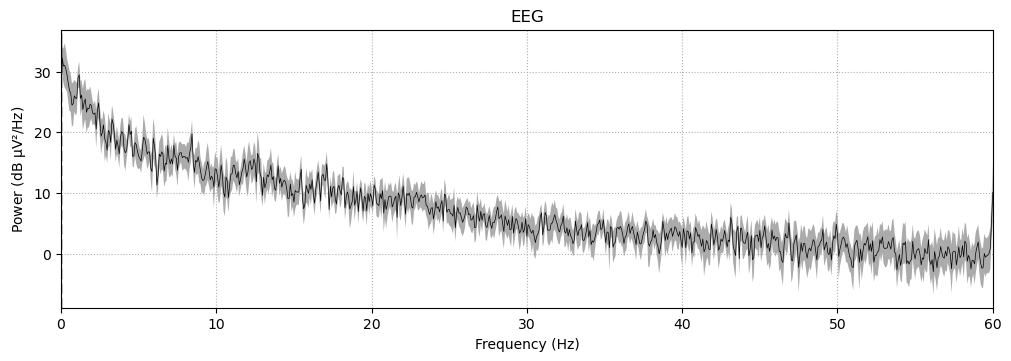

In [12]:
before.plot_psd(fmax=60, average=True)

# Modification

In [16]:
modification = before.copy()

In [23]:
import numpy as np
import mne

def _get_psd_mean(raw, fmax):
    """Return mean PSD across channels + freqs array."""
    spec = raw.compute_psd(fmax=fmax)                 
    psd, freqs = spec.get_data(return_freqs=True)     
    psd_mean = psd.mean(axis=0)
    return psd_mean, freqs

def auto_notch_freqs(raw, max_harm=5, margin=0.5, search_bw=1.0):
    """
    Deteksi 50/60 Hz dari PSD rata-rata (pakai jendela ±search_bw) dan
    kembalikan daftar harmonik < Nyquist - margin.
    """
    nyq = float(raw.info['sfreq']) / 2.0
    fmax = min(120.0, nyq)
    psd_mean, freqs = _get_psd_mean(raw, fmax=fmax)

    def peak_power_around(f0):
        mask = (freqs >= (f0 - search_bw)) & (freqs <= (f0 + search_bw))
        if not mask.any():
            return -np.inf
        return psd_mean[mask].max()

    p50 = peak_power_around(50.0)
    p60 = peak_power_around(60.0)
    main = 50.0 if p50 >= p60 else 60.0

    harmonics = [h for h in (np.arange(1, max_harm + 1) * main) if h < (nyq - margin)]
    return harmonics

def preprocess_eeg(raw, l_freq=1.0, h_freq=40.0, notch='auto'):
    # 1) average reference
    raw.set_eeg_reference('average', verbose=False)

    # 2) notch
    if notch == 'auto':
        freqs = auto_notch_freqs(raw)
        if freqs:  
            raw.notch_filter(freqs=freqs, verbose=False)
    elif isinstance(notch, (int, float)):
        raw.notch_filter(freqs=[float(notch)], verbose=False)
    elif isinstance(notch, (list, tuple)):
        raw.notch_filter(freqs=list(notch), verbose=False)

    # 3) band-pass
    raw.filter(l_freq=l_freq, h_freq=h_freq, fir_design='firwin', verbose=False)
    return raw


In [24]:
from mne.datasets import eegbci
path = eegbci.load_data(1, runs=[1])[0]
raw = mne.io.read_raw_edf(path, preload=True)
raw_clean = preprocess_eeg(raw, l_freq=1, h_freq=40, notch='auto')


Extracting EDF parameters from /Users/syifani/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S001/S001R01.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 9759  =      0.000 ...    60.994 secs...
Effective window size : 12.800 (s)


NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
Effective window size : 12.800 (s)
Plotting power spectral density (dB=True).


/opt/anaconda3/lib/python3.12/site-packages/mne/viz/utils.py:158: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)


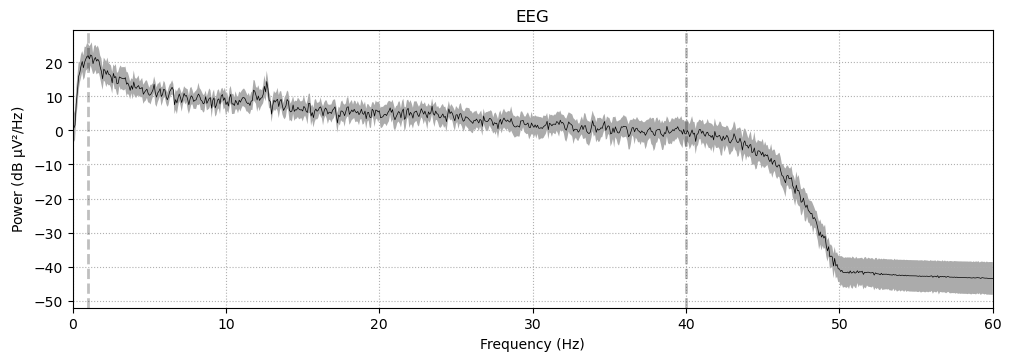

In [26]:
raw_clean.plot_psd(fmax=60, average=True)

NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
Effective window size : 12.800 (s)
Plotting power spectral density (dB=True).


/opt/anaconda3/lib/python3.12/site-packages/mne/viz/utils.py:158: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)


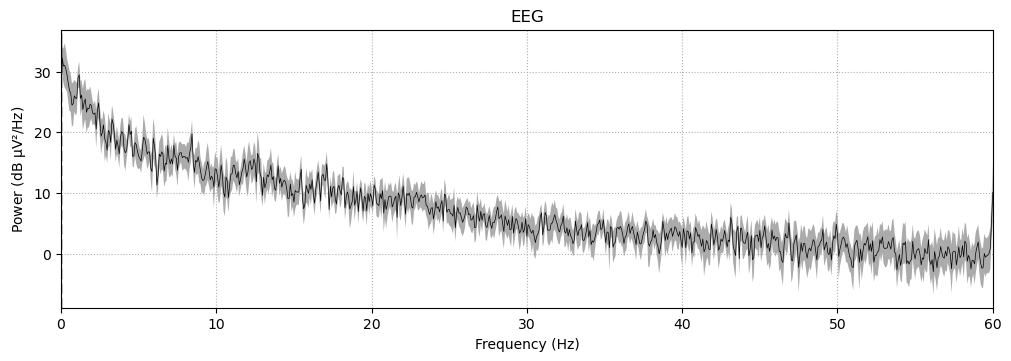

In [29]:
before.plot_psd(fmax=60, average=True)

#####

1️⃣ Grafik Atas — Before filtering
Sumbu X = frekuensi (Hz)

Sumbu Y = power spektral rata-rata di seluruh channel EEG (dB µV²/Hz).

Kurva terlihat turun secara umum dari frekuensi rendah (1–10 Hz) ke menengah (20–40 Hz).

Di sekitar 50 Hz (dan sedikit di harmoniknya) ada spike yang cukup tajam — ini adalah mains noise dari listrik PLN.

Setelah 40–50 Hz ada drop drastis → kemungkinan karena sebelumnya kamu set h_freq=40 jadi di plot ini frekuensi di atasnya udah attenuated.

2️⃣ Grafik Bawah — After filtering (auto-notch + bandpass 1–40 Hz)
Garis 50 Hz spike sudah hilang → berarti fungsi auto_notch_freqs sukses mendeteksi dan menghapus noise listrik.

Power spektral di seluruh rentang (1–40 Hz) jadi lebih mulus tanpa lonjakan besar di ujung.

Ada sedikit noise di frekuensi rendah (1–5 Hz) → ini normal karena EEG banyak sinyal slow-wave di sana.

📌 Interpretasi akhir
Notch filter berhasil menghapus noise listrik di 50 Hz (dan harmoniknya).

Band-pass 1–40 Hz berhasil memangkas artefak frekuensi sangat rendah (<1 Hz, drift) dan tinggi (>40 Hz, otot/EMG).

Data ini sekarang lebih siap untuk feature extraction (misal: band power delta, theta, alpha, beta, gamma) atau langsung masuk ke pipeline klasifikasi.
